##  SEÇÃO 1: IMPORTAÇÕES E CONFIGURAÇÕES GERAIS

**Objetivo:**
- Centralizar todas as importações.
- Definir constantes globais (URLs, seed).
- Facilitar manutenção do projeto.

In [6]:
from __future__ import annotations
from typing import Tuple, List, Dict

from pathlib import Path
from joblib import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.tree import export_text

URL_INTERNACOES = (
    "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/Final_Datasets/INTERNACOES_DOENCA_RESP_RJ_SEAZONALITY_FEATURES.csv"
)
URL_QUALIAR = (
    "https://raw.githubusercontent.com/EIC-BCC/25_2-QualiAr/refs/heads/main/data/Final_Datasets/INTERNACOES_DOENCA_RESP_RJ_QUALIAR_FEATURES.csv"
)

GLOBAL_RANDOM_STATE = 42
np.random.seed(GLOBAL_RANDOM_STATE)

##  SEÇÃO 2: CARREGAMENTO DOS DADOS BRUTOS
**Objetivo:**
- Carregar os datasets de internações e de sazonalidade/qualidade do ar.
- Encapsular essa lógica em função reutilizável.

In [7]:
def load_raw_data(
    url_internacoes: str = URL_INTERNACOES,
    url_qualiar: str = URL_QUALIAR
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Carrega os datasets brutos de internações e sazonalidade a partir das URLs.

    Retorna:
        df_internacoes: DataFrame com informações de internações.
        df_qualiar: DataFrame com features sazonais/ambientais.
    """
    df_internacoes = pd.read_csv(url_internacoes, encoding="utf-8")
    df_qualiar = pd.read_csv(url_qualiar, encoding="utf-8")
    return df_internacoes, df_qualiar

In [8]:
df_internacoes, df_qualiar = load_raw_data()

###  SEÇÃO 2.1: CONSTRUÇÃO DO DATAFRAME UNIFICADO

**Objetivo:**
- Unificar bases em um único DataFrame.
- Garantir ordenação temporal, limpeza básica e definição do alvo `y`.
- Esta estrutura é a base para RF


In [9]:
def build_unified_dataset(
    df_internacoes: pd.DataFrame,
    df_qualiar: pd.DataFrame,
    date_col: str = "data_dia",
    target_col_name: str = "y"
) -> pd.DataFrame:
    """
    Unifica as bases de internações e sazonalidade em um único DataFrame diário.

    Passos:
        - Merge pelo campo de data.
        - Ordena por data.
        - Remove colunas redundantes ou conflitantes.
        - Renomeia o alvo final para 'y' (antes `target_x`).
        - Garante tipo numérico para o alvo.

    Retorna:
        df_unificado: DataFrame pronto para preparação de features.
    """
    df = (
        pd.merge(df_internacoes, df_qualiar, on=date_col, how="left")
        .sort_values(date_col)
        .reset_index(drop=True)
    )
    
    # Remove colunas que podem conflitar ou não são necessárias aqui.
    cols_drop = ["ano", "mes", "dia", "target_y", "estacao", "estacao_id", "dow"]
    df.drop(columns=cols_drop, inplace=True, errors="ignore")

    # Renomeia alvo principal
    df.rename(columns={"target_x": target_col_name}, inplace=True)

    # Garante alvo numérico
    df[target_col_name] = pd.to_numeric(df[target_col_name], errors="coerce").astype(float)

    # Log informativo (ajuda debug, pode ser substituído por logging futuramente)
    print("Dimensões do unificado:", df.shape)
    print("Intervalo de datas:", df[date_col].min(), "→", df[date_col].max())
    print("\nColunas:", df.columns.tolist())
    print("\nTipos de dados:")
    print(df.dtypes)

    return df

In [10]:
df_unificado = build_unified_dataset(df_internacoes, df_qualiar)

Dimensões do unificado: (4018, 42)
Intervalo de datas: 2013-12-31 → 2024-12-30

Colunas: ['data_dia', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'y', 'ma_3', 'ma_7', 'ma_14', 'mes_sin', 'mes_cos', 'dow_sin', 'dow_cos', 'is_weekend', 'is_monday', 'stl365_seasonal', 'stl365_resid_vol30', 'stl365_season_amp', 'estacao_sin', 'estacao_cos', 'no_t', 'no2_t', 'nox_t', 'o3_t', 'nox_x_o3_t', 'no_lag1', 'no_lag7', 'o3_lag1', 'o3_lag7', 'pm10_lag1', 'pm2_5_lag1', 'so2_lag12', 'no_ma60_s1', 'nox_ma60_s1', 'no2_ma30_s1', 'o3_ma150_s1', 'so2_ma150_s21', 'pm10_ma30_s1', 'pm2_5_ma7_s1']

Tipos de dados:
data_dia               object
lag_1                 float64
lag_2                 float64
lag_3                 float64
lag_4                 float64
lag_5                 float64
lag_6                 float64
lag_7                 float64
y                     float64
ma_3                  float64
ma_7                  float64
ma_14                 float64
mes_sin               flo

In [ ]:
# display(df_unificado[['ma_3', 'ma_7', 'stl365_seasonal', 'stl365_season_amp']].head())

# cols = ['stl365_seasonal', 'stl365_season_amp']

# df_unificado[cols] = df_unificado[cols].shift(1)

# display(df_unificado[['ma_3', 'ma_7', 'stl365_seasonal', 'stl365_season_amp']].head())

,ma_3,ma_7,stl365_seasonal,stl365_season_amp
0,339.666667,340.857143,-38.678232,893.163309
1,327.333333,343.571429,-227.248453,893.395145
2,311.666667,362.000000,-139.052015,893.397520
3,315.333333,340.285714,-25.717226,893.827038
4,410.666667,353.000000,62.812104,893.870569


,ma_3,ma_7,stl365_seasonal,stl365_season_amp
0,339.666667,340.857143,NaN,NaN
1,327.333333,343.571429,-38.678232,893.163309
2,311.666667,362.000000,-227.248453,893.395145
3,315.333333,340.285714,-139.052015,893.397520
4,410.666667,353.000000,-25.717226,893.827038


###  SEÇÃO 2.2: PLOT DA SÉRIE TEMPORAL

**Objetivo:**
- Visualizar a série temporal das internações


In [11]:
def plot_internacoes_mm_separadas(
    df_unificado: pd.DataFrame,
    date_col: str = "data_dia",
    target_col: str = "y",
    windows: tuple[int, ...] = (7, 14, 30, 60, 90),
    center: bool = True,
) -> None:
    df = df_unificado.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col)

    ts = df.set_index(date_col)[target_col].astype(float)
    mean_val = ts.mean(skipna=True)

    for w in windows:
        mm = ts.rolling(window=w, center=center, min_periods=1).mean()

        plt.figure(figsize=(12, 5))
        plt.plot(ts.index, ts.values, label="Diário", alpha=0.6, linewidth=1)
        plt.plot(ts.index, mm.values, label=f"Média móvel {w} dias", linewidth=2)
        plt.axhline(mean_val, linestyle="--", linewidth=1.5, label=f"Média ({mean_val:.1f})")

        plt.title(f"Série Temporal de Internações (MM {w} dias)")
        plt.xlabel("Data")
        plt.ylabel("Internações/dia")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.gcf().autofmt_xdate()
        plt.show()

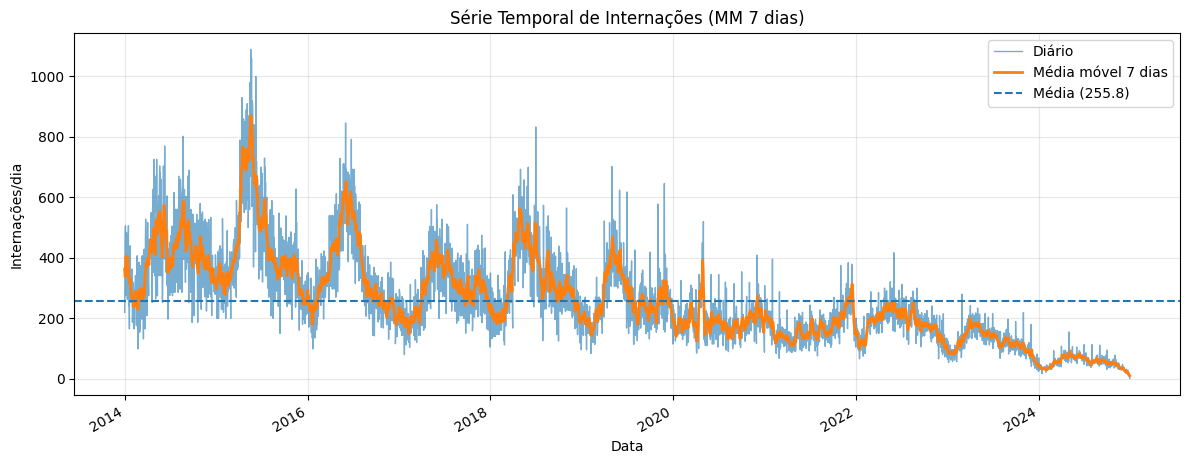

In [18]:
plot_internacoes_mm_separadas(df_unificado, windows=([7]))

## SEÇÃO 4: FUNÇÕES UTILITÁRIAS (MÉTRICAS E PESOS)

**Objetivo:**
- Centralizar métricas e geração de pesos.
- Reutilizar na avaliação do Random Forest.

**Ponderação por Recência (Temporal Weighting)**

**Objetivo:** Dar mais importância a observações recentes durante o treinamento do modelo, refletindo a intuição de que padrões mais atuais são mais relevantes para previsão.

In [19]:
def make_recency_weights(
    index: pd.DatetimeIndex,
    low: float = 0.5,
    high: float = 1.5
) -> pd.Series:
    """
    Gera pesos crescentes no tempo:
        - Amostras mais recentes recebem peso maior.
        - Útil para dar mais importância aos anos finais.

    Retorna:
        Série com mesmo índice temporal e pesos normalizados no intervalo [low, high].
    """
    t = (index - index.min()).days.astype(float)
    w = low + (high - low) * (t - t.min()) / (t.max() - t.min() + 1e-9)
    return pd.Series(w, index=index).clip(lower=low, upper=high)

Métrica que mede o erro percentual médio entre valores previstos e observados, de forma simétrica.

In [20]:
def smape(y_true, y_pred) -> float:
    """Calcula sMAPE (%) entre valores observados e previstos."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-9)
    )

In [21]:
def wmape(y_true, y_pred) -> float:
    """Calcula WMAPE (%) ponderando pelo total observado."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + 1e-9)

In [22]:
def bias(y_true, y_pred) -> float:
    """
    Calcula o Bias médio do modelo.

    Definição:
        Bias = média de (y_pred - y_true)

    Interpretação:
        - Bias < 0: modelo tende a subestimar (underprediction).
        - Bias > 0: modelo tende a superestimar (overprediction).
        - Bias ≈ 0: modelo sem viés sistemático relevante.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(y_pred - y_true))

In [23]:
def evaluate_predictions(y_true, y_pred) -> Dict[str, float]:
    """
    Calcula métricas padrão de avaliação do modelo.

    Retorna:
        dict com:MAE, RMSE, R2, sMAPE, WMAPE, Bias (médio de y_pred - y_true)
    """
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "WMAPE": wmape(y_true, y_pred),
        "Bias": bias(y_true, y_pred),
    }

##  SEÇÃO 5: PREPARAÇÃO DE DADOS (ÍNDICE DIÁRIO, JANELAS, FEATURES)

**Objetivo:**
- Garantir série diária contínua (make_daily_frame).
- Gerar janelas temporais para RF/LSTM.
- Selecionar features importantes para o RF.

In [24]:
def make_daily_frame(
    df: pd.DataFrame,
    date_col: str,
    target_col: str,
    ffill_limit: int = 14,
    categorical_cols: List[str] | None = None
) -> pd.DataFrame:
    """
    Cria uma série diária contínua a partir dos dados originais.

    Passos:
        - Converte coluna de data para datetime e ordena.
        - Reindexa para ter TODAS as datas (freq='D').
        - Cria colunas *_missing indicando pontos de falta.
        - Aplica forward-fill limitado nos preditores (não altera o alvo).

    Obs:
        - Forward-fill é limitado para evitar uso de informação muito distante.
    """
    data = df.copy()
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")
    data = data.sort_values(date_col).set_index(date_col)

    full_idx = pd.date_range(data.index.min(), data.index.max(), freq="D")
    data = data.reindex(full_idx)

    if categorical_cols is None:
        categorical_cols = []

    num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)

    cat_cols = [c for c in categorical_cols if c in data.columns]

    # Flags de missing ANTES da imputação
    for c in num_cols + cat_cols:
        data[f"{c}_missing"] = data[c].isna().astype(int)

    # Forward-fill limitado em variáveis numéricas
    for c in num_cols:
        data[c] = data[c].ffill(limit=ffill_limit)

    # Forward-fill mais curto em categóricas
    for c in cat_cols:
        data[c] = data[c].ffill(limit=min(3, ffill_limit))

    return data

In [25]:
def compute_causal_trend(
    y: pd.Series,
    window: int = 365,
    min_periods: int = 90
) -> pd.Series:
    """
    Estima uma tendência lenta e CAUSAL para a série de internações.

    Estratégia:
    - Usa média móvel somente com dados do PASSADO (center=False),
      evitando vazamento de informação.
    - Para o início da série (antes da janela completa), usa média
      acumulada crescente como aproximação.

    Parâmetros:
        y: série original (já alinhada no índice diário).
        window: tamanho da janela para tendência de longo prazo (default: 365 dias).
        min_periods: mínimo de observações para começar a calcular a média móvel.

    Retorna:
        Série 'trend' alinhada com y.
    """
    y = y.astype(float)

    # Média móvel causal (apenas passado)
    trend = y.rolling(window=window, min_periods=min_periods, center=False).mean()

    # Para o início, onde ainda é NaN, usa média acumulada (também causal)
    early_mask = trend.isna()
    if early_mask.any():
        trend[early_mask] = y.expanding(min_periods=1).mean()[early_mask]

    return trend

In [26]:
def apply_rolling_window(
    time_series_array: np.ndarray,
    initial_time_step: int,
    max_time_step: int,
    window_size: int,
    target_idx: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Cria janelas temporais causais para previsão 1 passo à frente.

    Entradas:
        time_series_array: matriz [tempo, features].
        window_size: tamanho da janela (n dias passados).
        target_idx: índice da coluna do alvo em time_series_array.

    Saída:
        X: [amostras, window_size, n_features]
        y: [amostras] -> valor do alvo imediatamente após cada janela.
    """
    assert 0 <= target_idx < time_series_array.shape[1]
    assert initial_time_step >= 0
    assert max_time_step >= initial_time_step

    start = initial_time_step
    sub_windows = (
        start
        + np.expand_dims(np.arange(window_size), 0)
        + np.expand_dims(np.arange(max_time_step + 1), 0).T
    )

    X = time_series_array[sub_windows]
    y = time_series_array[window_size:(max_time_step + window_size + 1), target_idx]

    # Garante que não há NaN no alvo (se houver, é erro de preparação)
    if np.any(np.isnan(y)):
        raise ValueError("Há valores NaN em y após criação das janelas.")

    return X, y

In [27]:
def rolling_to_tabular(
    df_windowed: pd.DataFrame,
    window_size: int,
    target_col: str,
    date_index: pd.DatetimeIndex
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, List[str]]:
    """
    Converte uma série multivariada em:

        - X_flat (2D) para modelos tabulares (RF).
        - y (1D) alvo.
        - X_seq (3D) para modelos sequenciais (LSTM).
        - seq_cols: lista de colunas na ordem usada nos canais.

    Estratégia:
        - Usa apply_rolling_window para gerar janelas.
        - Achata as janelas para RF (lags explodidos).
        - Mantém tensor 3D para LSTM.
    """
    cols = df_windowed.columns.tolist()
    target_idx = cols.index(target_col)

    A = df_windowed.to_numpy()
    max_ts = len(df_windowed) - window_size - 1

    X3d, y = apply_rolling_window(
        A,
        initial_time_step=0,
        max_time_step=max_ts,
        window_size=window_size,
        target_idx=target_idx
    )

    ns, w, nf = X3d.shape
    X2d = X3d.reshape(ns, w * nf)

    names = [
        f"{c}_t-{lag}"
        for lag in range(1, window_size + 1)
        for c in cols
    ]

    idx = date_index[window_size:(max_ts + window_size + 1)]
    X_flat = pd.DataFrame(X2d, columns=names, index=idx)

    return X_flat, y, X3d, cols

In [28]:
def select_top_features(
    X: pd.DataFrame,
    y: np.ndarray,
    pre: ColumnTransformer,
    n_splits: int = 4,
    random_state: int = 42,
    k: int = 8,
    gap_days: int = 7
) -> List[str]:
    """
    Seleciona as top-k features com base em importância por permutação.

    Estratégia:
        - Treina um Random Forest com validação temporal (TimeSeriesSplit).
        - Calcula permutation importance nos últimos folds (mais recentes).
        - Retorna as k features mais importantes.

    Observação importante:
        - NÃO aplicamos log1p no alvo aqui, pois em cenários com detrending
          o alvo pode assumir valores negativos (resíduos). Usar log1p
          geraria NaN e quebraria o ajuste.
    """
    try:
        tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap_days)
    except TypeError:
        tscv = TimeSeriesSplit(n_splits=n_splits)

    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features="sqrt",
        random_state=random_state,
        n_jobs=-1
    )

    # Transformação identidade no alvo (serve para y original ou detrendido)
    ttr = TransformedTargetRegressor(
        regressor=base_rf,
        func=lambda x: x,
        inverse_func=lambda x: x
    )

    pipe = Pipeline([("pre", pre), ("rf", ttr)])

    importances_list = []
    folds = list(tscv.split(X))

    # Usa os últimos folds (mais recentes) para importância
    for tr_idx, va_idx in folds[-min(3, len(folds)):]:
        pipe.fit(X.iloc[tr_idx], y[tr_idx])
        imp = permutation_importance(
            pipe,
            X.iloc[va_idx],
            y[va_idx],
            n_repeats=10,
            random_state=random_state,
            scoring="neg_mean_absolute_error"
        )
        importances_list.append(pd.Series(imp.importances_mean, index=X.columns))

    mean_importances = pd.concat(importances_list, axis=1).mean(axis=1)
    return mean_importances.sort_values(ascending=False).head(k).index.tolist()

##  SEÇÃO 6: PIPELINE DO RANDOM FOREST (TREINO, TUNING, AVALIAÇÃO)

**Objetivo:**
- Preparar dados tabulares.
- Realizar seleção de features.
- Rodar RandomizedSearchCV com TimeSeriesSplit.
- Gerar métricas e gráficos.

In [29]:
def tune_and_fit_rf_simplified(
    X: pd.DataFrame,
    y: np.ndarray,
    preprocessor: ColumnTransformer,
    n_splits: int = 5,
    random_state: int = 42,
    use_log_transform: bool = True,
) -> Pipeline:
    """
    Cria pipeline (preprocessamento + RF envolto em TransformedTargetRegressor)
    e executa RandomizedSearchCV com validação temporal.

    Obs:
        - Aplica log1p no alvo internamente (robustece extremos).
        - Usa pesos de recência no ajuste final.
        - TODO: expor espaço de busca como parâmetro externo.
    """
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=10,
        min_samples_split=10,
        max_features="sqrt",
        bootstrap=True,
        n_jobs=-1,
        random_state=random_state
    )

    if use_log_transform:
        ttr = TransformedTargetRegressor(
            regressor=base_rf,
            func=np.log1p,
            inverse_func=np.expm1
        )
    else:
        # identidade sem lambda (picklable)
        ttr = TransformedTargetRegressor(
            regressor=base_rf,
            transformer=FunctionTransformer(validate=False)
        )


    pipe = Pipeline([
        ("pre", preprocessor),
        ("rf", ttr),
    ])

    param_dist = {
        "rf__regressor__n_estimators": [300, 400, 600],
        "rf__regressor__max_depth": [8, 12, 16],
        "rf__regressor__min_samples_leaf": [5, 10, 20],
        "rf__regressor__min_samples_split": [5, 10, 20],
        "rf__regressor__max_features": ["sqrt", 0.5],
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)

    recency_weights = make_recency_weights(X.index, low=0.7, high=2.0).values

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=12,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        random_state=random_state,
        refit=True,
        verbose=0,
    )

    search.fit(X, y, rf__sample_weight=recency_weights)

    return search.best_estimator_

In [30]:
def print_one_tree(
    model: Pipeline,
    feature_names: List[str],
    estimator_idx: int = 0
) -> None:
    """
    Imprime uma das árvores do Random Forest (útil para interpretação).

    Obs:
        - Apenas para inspeção qualitativa.
    """
    rf = model.named_steps["rf"].regressor_
    tree = rf.estimators_[estimator_idx]

    txt = export_text(tree, feature_names=feature_names[:tree.n_features_in_])
    print(txt)

In [31]:
def predict_and_plot_rf(
    model: Pipeline,
    X: pd.DataFrame,
    y_true: np.ndarray,
    title: str,
    trend: pd.Series | None = None,
) -> Dict:
    """
    Gera previsões com RF, com ou sem detrending.

    - Se 'trend' for fornecido, assume que o modelo previu o componente
      detrendido e soma a tendência de volta.
    - Caso contrário, usa diretamente a saída do modelo.
    """
    y_hat_model = model.predict(X)

    if trend is not None:
        trend_aligned = trend.loc[X.index]
        y_hat = y_hat_model + trend_aligned.values
    else:
        y_hat = y_hat_model

    y_hat = np.clip(y_hat, 0, None)
    metrics = evaluate_predictions(y_true, y_hat)

    df_plot = pd.DataFrame(
        {"y_true": y_true, "y_pred": y_hat},
        index=X.index
    )

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot.index, df_plot["y_true"], label="Observado", lw=1.2)
    plt.plot(df_plot.index, df_plot["y_pred"], label="Previsto (RF)", lw=1.2)
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Internações / dia")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {"metrics": metrics, "pred_df": df_plot}

In [32]:
def prepare_rolling_dataset(
    df_unificado: pd.DataFrame,
    date_col: str = "data_dia",
    target_col: str = "y",
    categorical_cols: List[str] = ("Qualidade_do_Ar",),
    window_size: int = 14,
    test_size: float = 0.2,
    gap_days: int = 7,
    k_features: int = 12,
    random_state: int = 42,
    use_windowing_for_rf: bool = False,
    detrend_target: bool = True,
) -> Dict:
    """
    Prepara dados apenas para o caminho TABULAR (Random Forest).

    Passos:
        1. Garante série diária contínua (make_daily_frame).
        2. Define X e y:
            - Opção padrão (use_windowing_for_rf=False):
                usa diretamente as features já criadas (lags, médias, etc.).
            - Opção alternativa:
                aplica janelamento (rolling_to_tabular) para gerar lags explodidos.
        3. Separa treino e teste respeitando a ordem temporal e aplicando um gap.
        4. Monta pré-processador (numéricas + categóricas).
        5. Faz seleção de top-k features via permutation importance.

    Retorna:
        dict com:
            X_train, y_train, X_test, y_test,
            preprocessor (ColumnTransformer),
            features_kept,
            idx_train, idx_test.
    """
    # 1) Série diária contínua
    base = make_daily_frame(
        df_unificado.copy(),
        date_col=date_col,
        target_col=target_col,
        ffill_limit=14,
        categorical_cols=list(categorical_cols)
    )
    base = base.sort_index()
    
    if detrend_target:
        base["trend_causal_365"] = compute_causal_trend(base[target_col])
        base["y_detrended"] = base[target_col] - base["trend_causal_365"]
        target_used = "y_detrended"
    else:
        base["trend_causal_365"] = np.nan
        target_used = target_col

    # 2) Definição de X e y para RF
    if use_windowing_for_rf:
        feat_cols_for_rf = [
            c for c in base.columns
            if c not in (target_col, target_used, "trend_causal_365")
        ]
        X_full_tab, y_full_tab, _, _ = rolling_to_tabular(
            base[feat_cols_for_rf + [target_used]],
            window_size=window_size,
            target_col=target_used,
            date_index=base.index
        )
        trend_series = None if not detrend_target else base["trend_causal_365"].iloc[window_size:-1]
    else:
        mask_y = base[target_used].notna()
        base_model = base.loc[mask_y, :]

        feat_cols_for_rf = [
            c for c in base_model.columns
            if c not in (target_col, target_used, "trend_causal_365")
        ]

        X_full_tab = base_model[feat_cols_for_rf].copy()
        y_full_tab = base_model[target_used].astype(float).to_numpy()

        trend_series = (
            None if not detrend_target
            else base_model["trend_causal_365"]
        )

        y_full_orig = base_model[target_col].astype(float).to_numpy()

    # 3) Split temporal treino/teste com gap
    n = len(X_full_tab)
    cut = int(np.floor((1 - test_size) * n))
    train_idx = slice(0, max(cut - gap_days, 0))
    test_idx = slice(cut, n)

    X_train = X_full_tab.iloc[train_idx]
    y_train = y_full_tab[train_idx]
    X_test = X_full_tab.iloc[test_idx]
    y_test = y_full_tab[test_idx]
    
    if detrend_target:
        trend_train = trend_series.iloc[train_idx]
        trend_test = trend_series.iloc[test_idx]
        y_train_orig = y_full_orig[train_idx]
        y_test_orig = y_full_orig[test_idx]
    else:
        trend_train = trend_test = None
        y_train_orig = y_train
        y_test_orig = y_test
        
    # 4) Define colunas categóricas/numéricas com base nas features selecionadas
    cat_cols = [c for c in X_train.columns if c in set(categorical_cols)]
    num_cols = [c for c in X_train.columns if c not in cat_cols]

    pre_tmp = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop"
    )

    # 5) Seleção de top-k features
    topk = select_top_features(
        X_train,
        y_train,
        pre=pre_tmp,
        n_splits=4,
        random_state=random_state,
        k=k_features
    )
    features_kept = list(topk)

    # Subconjunto final com somente as melhores features
    X_train_sel = X_train[features_kept].copy()
    X_test_sel = X_test[features_kept].copy()

    # Atualiza preprocessor para apenas essas colunas
    cat_cols_sel = [c for c in features_kept if c in set(categorical_cols)]
    num_cols_sel = [c for c in features_kept if c not in cat_cols_sel]

    pre_sel = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols_sel),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols_sel),
        ],
        remainder="drop"
    )

    return {
        "X_train": X_train_sel,
        "y_train": y_train,
        "X_test": X_test_sel,
        "y_test": y_test,
        "y_train_orig": y_train_orig,
        "y_test_orig": y_test_orig,
        "trend_train": trend_train,
        "trend_test": trend_test,
        "preprocessor": pre_sel,
        "features_kept": features_kept,
        "idx_train": X_train_sel.index,
        "idx_test": X_test_sel.index,
        "detrend_target": detrend_target,
    }


In [33]:
def run_pipeline_rf_rolling(
    df_unificado: pd.DataFrame,
    date_col: str = "data_dia",
    target_col: str = "y",
    categorical_cols: List[str] = ("Qualidade_do_Ar",),
    window_size: int = 14,
    test_size: float = 0.2,
    gap_days: int = 7,
    k_features: int = 12,
    random_state: int = 42,
    detrend_target=True,
) -> Dict:
    """
    Executa a pipeline completa do Random Forest:

        1. Prepara dados (prepare_rolling_dataset).
        2. Faz tuning simplificado do RF com validação temporal.
        3. Gera previsões em treino e teste, com gráficos.
        4. Exibe uma árvore para interpretação.

    Retorna:
        dict com modelo, features usadas, métricas e DataFrames de previsão.
    """
    prepared = prepare_rolling_dataset(
        df_unificado=df_unificado,
        date_col=date_col,
        target_col=target_col,
        categorical_cols=categorical_cols,
        window_size=window_size,
        test_size=test_size,
        gap_days=gap_days,
        k_features=k_features,
        random_state=random_state,
        use_windowing_for_rf=False,  # pode ligar se quiser usar janelamento
        detrend_target=detrend_target,
    )

    X_train = prepared["X_train"]
    y_train = prepared["y_train"]              # alvo usado no treino (detrendido)
    X_test = prepared["X_test"]
    y_test = prepared["y_test"]
    y_train_orig = prepared["y_train_orig"]    # alvo original
    y_test_orig = prepared["y_test_orig"]
    trend_train = prepared["trend_train"]
    trend_test = prepared["trend_test"]
    pre_sel = prepared["preprocessor"]
    topk = prepared["features_kept"]
    detrended = prepared["detrend_target"]

    # Treina RF com busca de hiperparâmetros
    best_model = tune_and_fit_rf_simplified(
        X_train,
        y_train,
        preprocessor=pre_sel,
        n_splits=5,
        random_state=random_state,
        use_log_transform=not detrended,  # sem log se estiver usando resíduos
    )

    # Avaliação em treino e teste
    train_res = predict_and_plot_rf(
        best_model,
        X_train,
        y_train_orig,  # alvo original com nível
        "Real x Previsto — RF (Treino)",
        trend=trend_train if detrended else None,
    )

    test_res = predict_and_plot_rf(
        best_model,
        X_test,
        y_test_orig,  # alvo original
        "Real x Previsto — RF (Teste)",
        trend=trend_test if detrended else None,
    )

    # Impressão de uma árvore de decisão para fins ilustrativos
    # print("\n===== Árvore 0 do Random Forest (resumo) =====")
    # print_one_tree(
    #     best_model,
    #     feature_names=X_train.columns.tolist(),
    #     estimator_idx=0
    # )

    return {
        "model": best_model,
        "features_kept": topk,
        "train_metrics": train_res["metrics"],
        "test_metrics": test_res["metrics"],
        "train_pred_df": train_res["pred_df"],
        "test_pred_df": test_res["pred_df"],
    }

##  SEÇÃO 7: EXECUÇÃO PRINCIPAL (MAIN)

**Objetivo:**
- Definir o fluxo end-to-end quando o script é executado diretamente.
- Mantém o comportamento focado SOMENTE em Random Forest.

In [34]:
df_unificado_recorte = df_unificado[
  (df_unificado["data_dia"] > "2013-12-30") &
  (df_unificado["data_dia"] < "2025-01-01")
].reset_index(drop=True)

print("\n[INFO] Recorte aplicado (2013-12-31 até 2019-12-31):")
display(df_unificado_recorte)


[INFO] Recorte aplicado (2013-12-31 até 2019-12-31):


,data_dia,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,y,ma_3,...,pm10_lag1,pm2_5_lag1,so2_lag12,no_ma60_s1,nox_ma60_s1,no2_ma30_s1,o3_ma150_s1,so2_ma150_s21,pm10_ma30_s1,pm2_5_ma7_s1
0,2013-12-31,407.0,355.0,257.0,417.0,570.0,179.0,201.0,220.0,327.333333,...,3.314950,4.556556,0.649022,1.858718,3.014845,4.223300,7.539419,1.631492,3.133194,4.589133
1,2014-01-01,220.0,407.0,355.0,257.0,417.0,570.0,179.0,308.0,311.666667,...,3.064610,NaN,0.983326,1.854354,3.009449,4.204743,7.536462,1.615786,3.132073,NaN
2,2014-01-02,308.0,220.0,407.0,355.0,257.0,417.0,570.0,418.0,315.333333,...,3.223175,3.871950,1.120986,1.839315,3.001289,4.160996,7.540516,1.607832,3.127586,NaN
3,2014-01-03,418.0,308.0,220.0,407.0,355.0,257.0,417.0,506.0,410.666667,...,3.048989,3.634441,1.482192,1.845058,3.006012,4.175899,7.548393,1.608439,3.124643,NaN
4,2014-01-04,506.0,418.0,308.0,220.0,407.0,355.0,257.0,297.0,407.000000,...,3.509400,4.616701,1.275512,1.845337,3.007049,4.169283,7.560182,1.600350,3.130042,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,2024-12-26,15.0,15.0,18.0,29.0,16.0,19.0,20.0,14.0,14.666667,...,2.848720,2.187406,3.423013,1.623844,2.787367,4.244590,9.062073,NaN,3.109845,2.766884
4014,2024-12-27,14.0,15.0,15.0,18.0,29.0,16.0,19.0,19.0,16.000000,...,2.825515,1.887857,2.254389,1.629781,2.797126,4.244529,9.031803,NaN,3.096580,2.643491
4015,2024-12-28,19.0,14.0,15.0,15.0,18.0,29.0,16.0,13.0,15.333333,...,2.746885,1.887857,2.331677,1.631756,2.800863,4.238049,9.009023,NaN,3.072986,2.567649
4016,2024-12-29,13.0,19.0,14.0,15.0,15.0,18.0,29.0,6.0,12.666667,...,2.671323,1.949165,3.378571,1.631274,2.802117,4.210229,9.016300,NaN,3.041910,2.396133


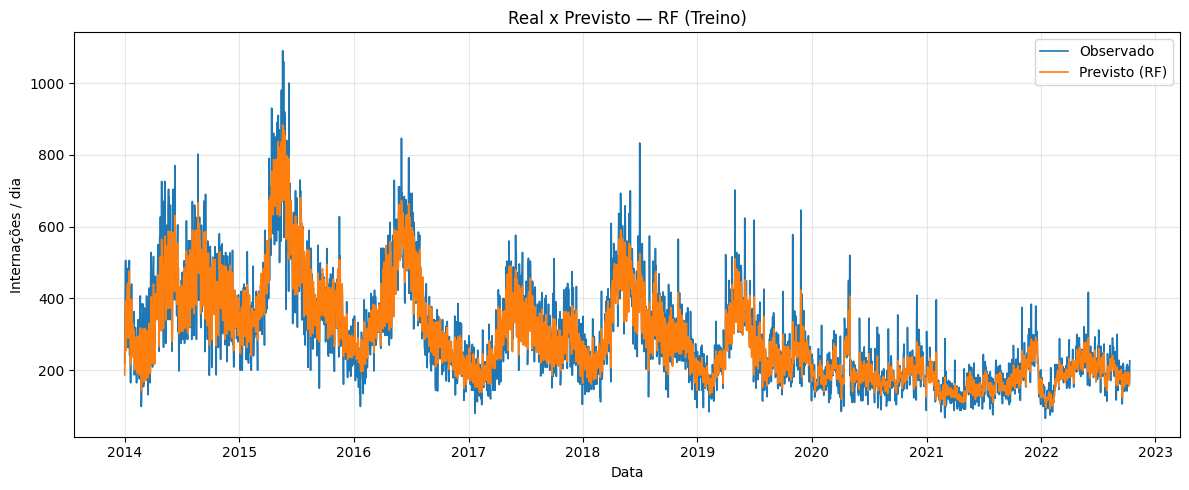

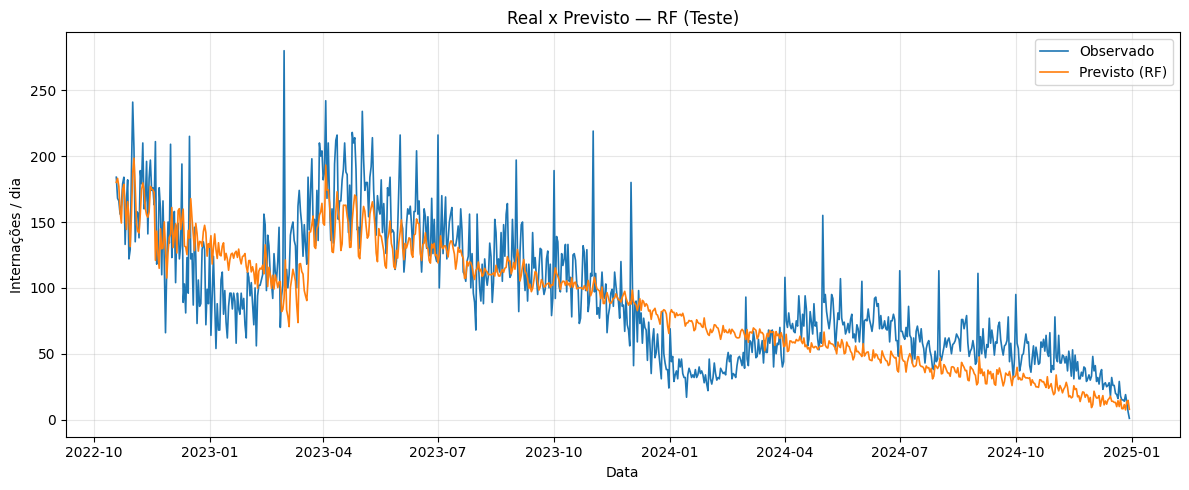

In [35]:
out_rf = run_pipeline_rf_rolling(
  df_unificado_recorte,
  date_col="data_dia",
  target_col="y",
  window_size=14,
  test_size=0.2,
  gap_days=7,
  k_features=16,
  random_state=GLOBAL_RANDOM_STATE,
  detrend_target=True
)

In [36]:
print("\n[RF] Features usadas:", out_rf["features_kept"])
print("[RF] Métricas Treino:", out_rf["train_metrics"])
print("[RF] Métricas Teste :", out_rf["test_metrics"])


[RF] Features usadas: ['ma_3', 'stl365_seasonal', 'is_weekend', 'ma_7', 'dow_sin', 'lag_7', 'pm10_ma30_s1', 'so2_ma150_s21', 'stl365_season_amp', 'stl365_resid_vol30', 'is_monday', 'o3_lag7', 'no_lag7', 'dow_cos', 'pm10_lag1', 'pm2_5_lag1']
[RF] Métricas Treino: {'MAE': 30.304145216088564, 'RMSE': np.float64(42.48206232011025), 'R2': 0.9144780215490751, 'sMAPE': np.float64(10.830149474018503), 'WMAPE': np.float64(10.216555589568708), 'Bias': 0.729141979540031}
[RF] Métricas Teste : {'MAE': 23.44777875596507, 'RMSE': np.float64(29.55713896357247), 'R2': 0.6429711922077342, 'sMAPE': np.float64(32.46459523467241), 'WMAPE': np.float64(24.97153961877191), 'Bias': -6.780425366033801}
